In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Optional

In [2]:
data_path = 'data/datasets/trading/point_output.csv'

In [3]:
data = pd.read_csv(data_path)
data = data.rename(columns={"Unnamed: 0": "DATE"})


In [4]:
data.head()

,DATE,ACTUAL,PREDICTED,ACTUAL_SCALED,PREDICTED_SCALED
0,2023-02-09 00:00:00,-7.427499,-0.624213,-0.084294,-0.044488
1,2023-02-09 01:00:00,-5.760001,-2.643388,-0.074538,-0.056302
2,2023-02-09 02:00:00,-6.822501,-5.403662,-0.080754,-0.072453
3,2023-02-09 03:00:00,-7.002500,-4.211674,-0.081808,-0.065478
4,2023-02-09 04:00:00,-15.269999,-0.263361,-0.130182,-0.042376


In [5]:
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d %H:%M:%S')

In [6]:
date_col_type = data['DATE'].dtype
date_col_type


dtype('<M8[ns]')

In [7]:
print(data.columns)


Index(['DATE', 'ACTUAL', 'PREDICTED', 'ACTUAL_SCALED', 'PREDICTED_SCALED'], dtype='object')


In [8]:
data.head()

,DATE,ACTUAL,PREDICTED,ACTUAL_SCALED,PREDICTED_SCALED
0,2023-02-09 00:00:00,-7.427499,-0.624213,-0.084294,-0.044488
1,2023-02-09 01:00:00,-5.760001,-2.643388,-0.074538,-0.056302
2,2023-02-09 02:00:00,-6.822501,-5.403662,-0.080754,-0.072453
3,2023-02-09 03:00:00,-7.002500,-4.211674,-0.081808,-0.065478
4,2023-02-09 04:00:00,-15.269999,-0.263361,-0.130182,-0.042376


In [9]:
def compute_frc_signal(frc_dart_col, tol):
    signal = np.where(
        np.abs(frc_dart_col) < tol, 0, 
        np.where(frc_dart_col > 0, 1, -1))
    return signal

In [10]:
def compute_naive_signal(actual_dart_col, tol):
    """
    Compute naive trading signal based on PAST actual values only.
    Uses the previous hour's actual value to predict current movement.
    This removes the look-ahead bias from the original implementation.
    """
    shifted = np.zeros_like(actual_dart_col)
    # Use previous hour's actual value (lag by 1) instead of future values
    shifted[1:] = actual_dart_col[:-1]
    
    signal = np.where(
        np.abs(shifted) < tol, 0, 
        np.where(shifted > 0, 1, -1))

    return signal

In [11]:
def timestep_pnl(actual_dart_col, signal_col):
    """Calculate PnL for a single timestep."""
    return actual_dart_col * signal_col

In [12]:
def trade_pnl(start_end_date_test:Tuple[str, str], 
              start_end_hour_trade:Tuple[int, int], 
              # dummy arg for now
              init_budget:int, 
              hourly_volume:float, 
              actual_dart_col_name:str,
              tol:float,
              df:pd.DataFrame,
              # this being None performs the
              # naive strategy
              forecast_dart_col_name:Optional[str]=None,
              date_col='DATE'):
        
        start_date = pd.to_datetime(start_end_date_test[0])
        end_date = pd.to_datetime(start_end_date_test[1])
            
        mask = (df['DATE'] >= start_date) & (df['DATE'] <= end_date)
        df = df.loc[mask].reset_index(drop=True)

        actual_dart_col = np.asarray(df[actual_dart_col_name])
        forecast_dart_col = None
        if forecast_dart_col_name is not None:
            forecast_dart_col = np.asarray(df[forecast_dart_col_name])
        
        signal = None 
        if forecast_dart_col is None:
            signal = compute_naive_signal(actual_dart_col, tol)
        else:
            signal = compute_frc_signal(forecast_dart_col, tol)
            
        hours = np.arange(len(signal)) % 24
        hour_mask = ((hours >= start_end_hour_trade[0]) & (hours <= start_end_hour_trade[1])).astype(int)
        
        pnl = hourly_volume * actual_dart_col * signal * hour_mask
        cumulative_pnl = np.cumsum(pnl)
        
        return {
            'date_idx': df[date_col],
            'PnL': pnl,
            'cumulative_PnL': cumulative_pnl,
            'signal': signal
        }

In [13]:
# test_start_date = test_data['DATE'].min().strftime('%Y-%m-%d %H:%M:%S')
# test_end_date = test_data['DATE'].max().strftime('%Y-%m-%d %H:%M:%S')

test_start_date = '2023-08-20 00:00:00'
test_end_date = '2025-01-07 23:00:00'

print(f"Testing period: {test_start_date} to {test_end_date}")

naive_data = trade_pnl(
    start_end_date_test=(test_start_date, test_end_date),
    start_end_hour_trade=(9, 17),
    init_budget=1e6,
    hourly_volume=1000,
    actual_dart_col_name='ACTUAL',
    tol=1e-2,
    df=data 
)

📅 Testing period: 2023-08-20 00:00:00 to 2025-01-07 23:00:00


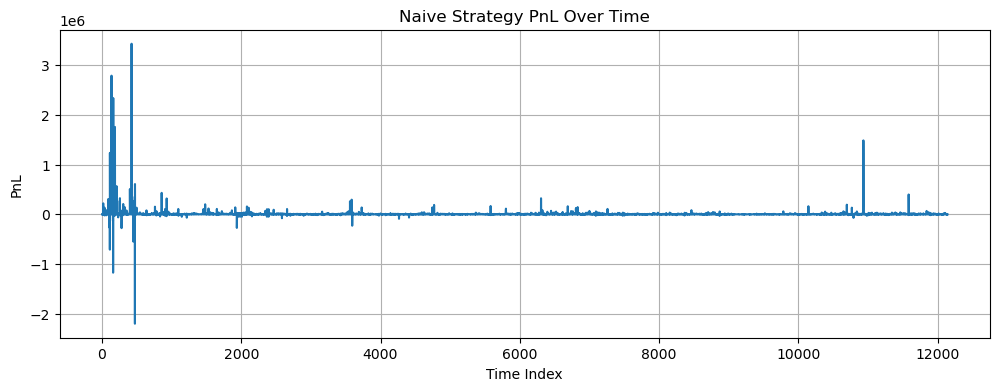

In [14]:

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(naive_data['PnL'])), naive_data['PnL'])
plt.xlabel('Time Index')
plt.ylabel('PnL')
plt.title('Naive Strategy PnL Over Time')
plt.grid(True)
plt.show()


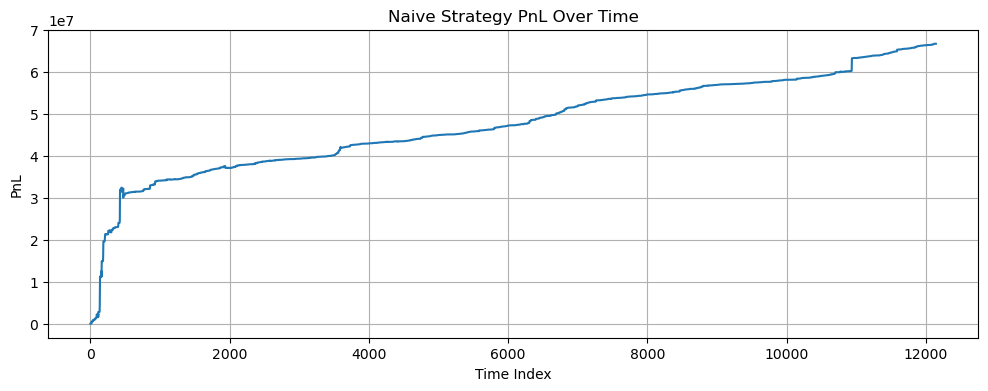

In [15]:

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(naive_data['cumulative_PnL'])), naive_data['cumulative_PnL'])
plt.xlabel('Time Index')
plt.ylabel('PnL')
plt.title('Naive Strategy PnL Over Time')
plt.grid(True)
plt.show()


In [16]:
# 🔧 **FIXED: Using test data only for forecast strategy**
frc_trade_data = trade_pnl(
    start_end_date_test=(test_start_date, test_end_date),
    start_end_hour_trade=(9, 19),
    init_budget=1e6,
    hourly_volume=1000,
    actual_dart_col_name='ACTUAL',
    tol=1e-2,
    df=data,  # Using test data only
    forecast_dart_col_name='PREDICTED'
)

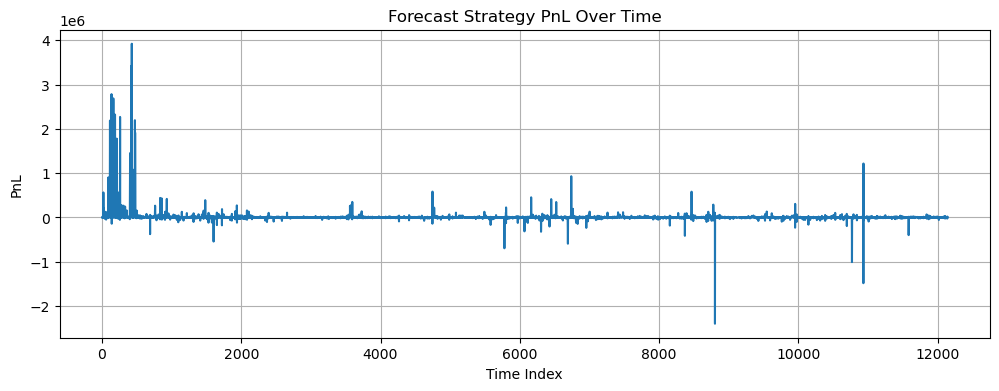

In [17]:

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(frc_trade_data['PnL'])), frc_trade_data['PnL'])
plt.xlabel('Time Index')
plt.ylabel('PnL')
plt.title('Forecast Strategy PnL Over Time')
plt.grid(True)
plt.show()

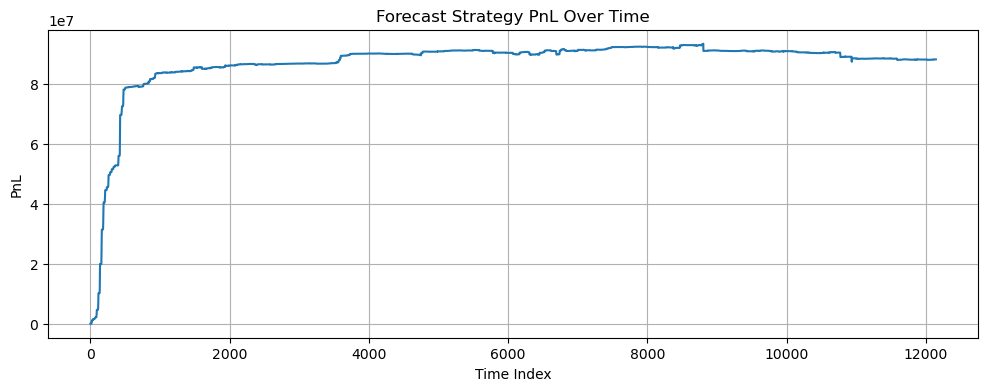

In [18]:

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(frc_trade_data['cumulative_PnL'])), frc_trade_data['cumulative_PnL'])
plt.xlabel('Time Index')
plt.ylabel('PnL')
plt.title('Forecast Strategy PnL Over Time')
plt.grid(True)
plt.show()

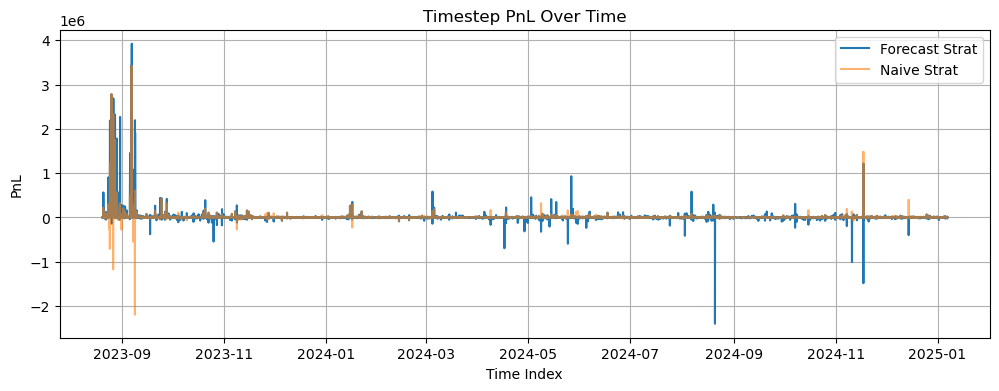

In [19]:
plt.figure(figsize=(12, 4))
X = frc_trade_data['date_idx']
plt.plot(X, frc_trade_data['PnL'], label='Forecast Strat')
plt.plot(X, naive_data['PnL'], label='Naive Strat', alpha=0.6)
plt.xlabel('Time Index')
plt.ylabel('PnL')
plt.title('Timestep PnL Over Time')
plt.legend()
plt.grid(True)
plt.show()

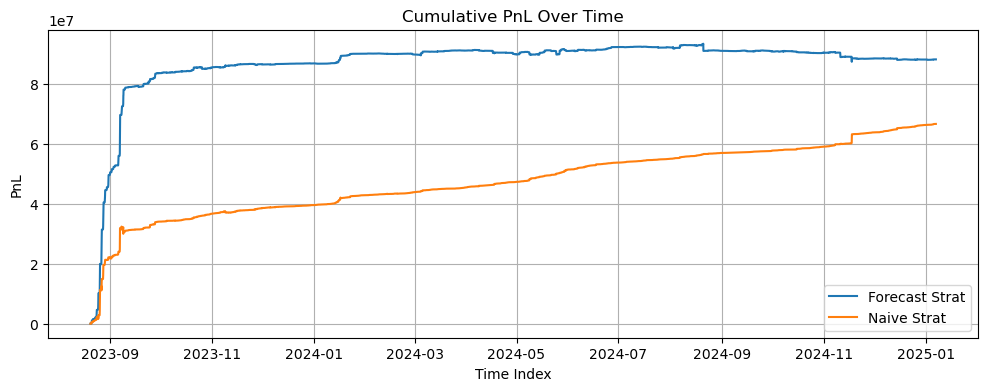

In [20]:
plt.figure(figsize=(12, 4))
X = frc_trade_data['date_idx']
plt.plot(X, frc_trade_data['cumulative_PnL'], label='Forecast Strat')
plt.plot(X, naive_data['cumulative_PnL'], label='Naive Strat')
plt.xlabel('Time Index')
plt.ylabel('PnL')
plt.title('Cumulative PnL Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
pnl_naive = naive_data['PnL']
cum_pnl_naive = naive_data['cumulative_PnL']

In [22]:
pnl_frc = frc_trade_data['PnL']
cum_pnl_frc = frc_trade_data['cumulative_PnL']

In [23]:
mean_pnl_naive = np.mean(pnl_naive)
mean_pnl_frc = np.mean(pnl_frc)

std_pnl_naive = np.std(pnl_naive)
std_pnl_frc = np.std(pnl_frc)

In [24]:
mean_pnl_naive

np.float64(5495.491629156476)

In [25]:
mean_pnl_frc

np.float64(7270.465490405272)

In [26]:
print("mu pnl Naive:", mean_pnl_naive)
print("mu pnl Forecast:", mean_pnl_frc)
print("\nsig pnl Naive:", std_pnl_naive)
print("sig pnl Forecast:", std_pnl_frc)

mu pnl Naive: 5495.491629156476
mu pnl Forecast: 7270.465490405272

sig pnl Naive: 77609.53257822912
sig pnl Forecast: 113051.31446552365


In [27]:
hit_rate_naive = np.mean(pnl_naive > 0)
hit_rate_naive

np.float64(0.3100296442687747)

In [28]:
hit_rate_frc = np.mean(pnl_frc > 0)
hit_rate_frc

np.float64(0.25082345191040845)

In [29]:
miss_rate_naive = np.mean(pnl_naive < 0)
miss_rate_naive

np.float64(0.06422924901185771)

In [30]:
miss_rate_frc = np.mean(pnl_frc < 0)
miss_rate_frc

np.float64(0.20709815546772067)

In [31]:
pos_naive = pnl_naive * (pnl_naive > 0)
neg_naive = pnl_naive * (pnl_naive < 0)

pos_frc = pnl_frc * (pnl_frc > 0)
neg_frc = pnl_frc * (pnl_frc < 0)

In [32]:
profit_factor_naive = np.sum(pos_naive) / np.abs(np.sum(neg_naive))
profit_factor_naive

np.float64(7.571170395068768)

In [33]:
profit_factor_frc = np.sum(pos_frc) / np.abs(np.sum(neg_frc))
profit_factor_frc

np.float64(3.487536836440195)

In [34]:
cummax_pnl_naive = np.maximum.accumulate(cum_pnl_naive)
drawdown_naive = (cum_pnl_naive - cummax_pnl_naive) / (cummax_pnl_naive + 1e-8)

In [35]:
cummax_pnl_frc = np.maximum.accumulate(cum_pnl_frc)
drawdown_frc = (cum_pnl_frc - cummax_pnl_frc) / (cummax_pnl_frc + 1e-8) 

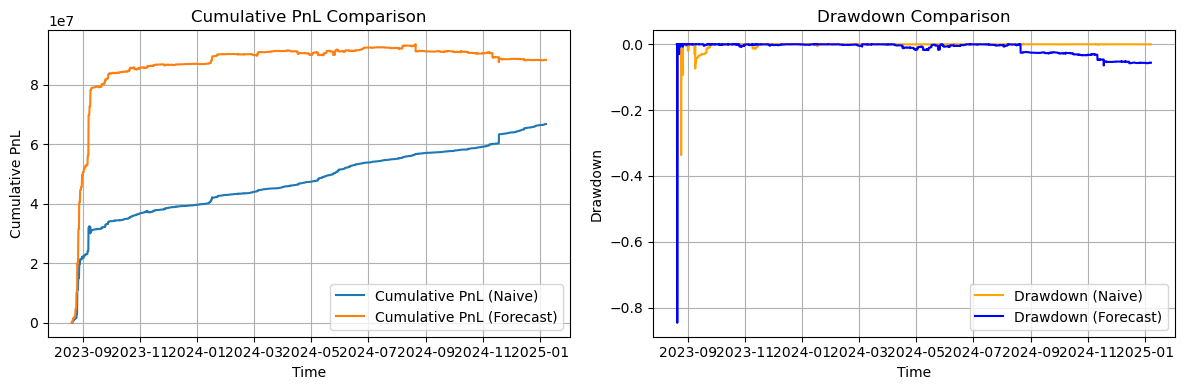

In [42]:
X = frc_trade_data['date_idx']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(X, cum_pnl_naive, label='Cumulative PnL (Naive)')
plt.plot(X, cum_pnl_frc, label='Cumulative PnL (Forecast)')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(X, drawdown_naive, label='Drawdown (Naive)', color='orange')
plt.plot(X, drawdown_frc, label='Drawdown (Forecast)', color='blue')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.title('Drawdown Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [37]:
mdd_naive = np.min(drawdown_naive)
mdd_naive

np.float64(-0.3478159477388463)

In [43]:
mdd_frc = np.min(drawdown_frc)
mdd_frc

np.float64(-0.8460640427905453)

In [38]:
returns_naive = pnl_naive
returns_frc = pnl_frc    

mean_ret_naive = np.mean(returns_naive)
std_ret_naive = np.std(returns_naive)
sharpe_naive = mean_ret_naive / (std_ret_naive + 1e-8)
annualized_sharpe_naive = sharpe_naive * np.sqrt(24 * 365)

mean_ret_frc = np.mean(returns_frc)
std_ret_frc = np.std(returns_frc)
sharpe_frc = mean_ret_frc / (std_ret_frc + 1e-8)
annualized_sharpe_frc = sharpe_frc * np.sqrt(24 * 365)

print("Annualized Sharpe Ratio (Naive):", annualized_sharpe_naive)
print("Annualized Sharpe Ratio (Forecast):", annualized_sharpe_frc)


Annualized Sharpe Ratio (Naive): 6.627405379488681
Annualized Sharpe Ratio (Forecast): 6.019198340675159


In [39]:
mar = 0.0

bad_dev_naive = np.minimum(0, returns_naive - mar)
downside_std_naive = np.sqrt(np.mean(bad_dev_naive**2))
sortino_naive = (mean_ret_naive - mar) / downside_std_naive
annualized_sortino_naive = sortino_naive * np.sqrt(24 * 365)

bad_dev_frc = np.minimum(0, returns_frc - mar)
downside_std_frc = np.sqrt(np.mean(bad_dev_frc**2))
sortino_frc = (mean_ret_frc - mar) / downside_std_frc
annualized_sortino_frc = sortino_frc * np.sqrt(24 * 365)

print("Annualized Sortino Ratio (Naive):", annualized_sortino_naive)
print("Annualized Sortino Ratio (Forecast):", annualized_sortino_frc)

Annualized Sortino Ratio (Naive): 20.532333219944615
Annualized Sortino Ratio (Forecast): 21.391454707694738


In [40]:
info_ratio_naive = (mean_ret_naive / (std_ret_naive + 1e-8)) * np.sqrt(24 * 365)
info_ratio_frc = (mean_ret_frc / (std_ret_frc + 1e-8)) * np.sqrt(24 * 365)

print("Annualized Information Ratio (Naive):", info_ratio_naive)
print("Annualized Information Ratio (Forecast):", info_ratio_frc)


Annualized Information Ratio (Naive): 6.627405379488681
Annualized Information Ratio (Forecast): 6.019198340675159


In [41]:


active_returns = returns_frc - returns_naive


mean_active = mean_ret_frc - mean_ret_naive


std_active = np.std(active_returns)


info_ratio = mean_active / std_active


annualized_info_ratio = info_ratio * np.sqrt(24 * 365)

print("Annualized Information Ratio (Forecast vs Naive):", annualized_info_ratio)

Annualized Information Ratio (Forecast vs Naive): 1.6394355925647877


In [45]:
comparison_data = {
    'Metric': [
        'Mean PnL',
        'Std PnL', 
        'Hit Rate (%)',
        'Miss Rate (%)',
        'Profit Factor',
        'Maximum Drawdown (%)',
        'Annualized Sharpe Ratio',
        'Annualized Sortino Ratio',
        'Annualized Information Ratio',
        'Final Cumulative PnL'
    ],
    'Naive Strategy': [
        f"{mean_pnl_naive:,.2f}",
        f"{std_pnl_naive:,.2f}",
        f"{hit_rate_naive*100:.2f}%",
        f"{miss_rate_naive*100:.2f}%", 
        f"{profit_factor_naive:.3f}",
        f"{mdd_naive*100:.2f}%",
        f"{annualized_sharpe_naive:.3f}",
        f"{annualized_sortino_naive:.3f}",
        f"{info_ratio_naive:.3f}",
        f"{cum_pnl_naive[-1]:,.2f}"
    ],
    'Forecast Strategy': [
        f"{mean_pnl_frc:,.2f}",
        f"{std_pnl_frc:,.2f}",
        f"{hit_rate_frc*100:.2f}%",
        f"{miss_rate_frc*100:.2f}%",
        f"{profit_factor_frc:.3f}",
        f"{mdd_frc*100:.2f}%",
        f"{annualized_sharpe_frc:.3f}",
        f"{annualized_sortino_frc:.3f}",
        f"{info_ratio_frc:.3f}",
        f"{cum_pnl_frc[-1]:,.2f}"
    ]
}
comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("TRADING STRATEGY PERFORMANCE COMPARISON")
print("="*80)
print(f"Testing Period: {test_start_date} to {test_end_date}")
print(f"Trading Hours: Naive (9-17), Forecast (9-19)")
print(f"Hourly Volume: 1,000 units")
print(f"Tolerance: 1e-2")
print("="*80)

print(f"{'Metric':<35} {'Naive Strategy':<20} {'Forecast Strategy':<20}")
print("-" * 80)
for i, row in comparison_df.iterrows():
    print(f"{row['Metric']:<35} {row['Naive Strategy']:<20} {row['Forecast Strategy']:<20}")

print("="*80)
print("ADDITIONAL INSIGHTS:")
print(f"• Active Information Ratio (Forecast vs Naive): {annualized_info_ratio:.3f}")
print(f"• Strategy Preference: {'Forecast' if mean_pnl_frc > mean_pnl_naive else 'Naive'} (Higher Mean PnL)")
print(f"• Risk-Adjusted Preference: {'Forecast' if annualized_sharpe_frc > annualized_sharpe_naive else 'Naive'} (Higher Sharpe Ratio)")
print(f"• Downside Protection: {'Forecast' if annualized_sortino_frc > annualized_sortino_naive else 'Naive'} (Higher Sortino Ratio)")
print("="*80)


TRADING STRATEGY PERFORMANCE COMPARISON
Testing Period: 2023-08-20 00:00:00 to 2025-01-07 23:00:00
Trading Hours: Naive (9-17), Forecast (9-19)
Hourly Volume: 1,000 units
Tolerance: 1e-2
Metric                              Naive Strategy       Forecast Strategy   
--------------------------------------------------------------------------------
Mean PnL                            5,495.49             7,270.47            
Std PnL                             77,609.53            113,051.31          
Hit Rate (%)                        31.00%               25.08%              
Miss Rate (%)                       6.42%                20.71%              
Profit Factor                       7.571                3.488               
Maximum Drawdown (%)                -34.78%              -84.61%             
Annualized Sharpe Ratio             6.627                6.019               
Annualized Sortino Ratio            20.532               21.391              
Annualized Information Ratio  